In [33]:
import os
os.chdir('/home/jpmarceaux/Simulations/KalmanFiltering_Sandia2021')
from kalman_gst import *
os.chdir('/home/jpmarceaux/Simulations/KalmanFiltering_Sandia2021/RiccatiEquation')
from pygsti.modelpacks import smq1Q_XYZI as std
import scipy

In [11]:
SEED = 2021
NUM_SHOTS = 256
np.random.seed(SEED)

In [16]:
# setup the fogi model and make a noisy model
target_model = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, target_model.state_space, elementary_errorgen_types='HS')
target_model.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
max_fogi_error_rate = 0.1
mdl_datagen = target_model.copy()
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [17]:
# check that the datagen model is CPTP and print metrics w.r.t. the target model
print('Model is CPTP... ', model_is_cptp(mdl_datagen))
print('avg. gate-set infidelity: ', avg_gs_infidelity(mdl_datagen, target_model))
print('mean square error: ', mserror(mdl_datagen, target_model))

Model is CPTP...  True
avg. gate-set infidelity:  0.09240756473428763
mean square error:  0.07711296129748693


In [47]:
# make an edesign and simulate data
maxLengths = [1,2,4,8,16,32,64]
edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, edesign, NUM_SHOTS, seed=SEED) #, sample_error='none')

In [48]:
# make MLE estimates 
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  128 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  258 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  531 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  874 circuits ---
Iterative GST Total Time: 2.7s
--- Iterative GST: [##################################################] 100.0%  1222 circuits ---
Iterative GST Total Time: 3.1s
--- Iterative GST: [##################################################] 100.0%  1570 circuits ---
Iterative GST Total Time: 4.6s
--- Iterative GST: [##################################################] 100.0%  1918 circuits ---
Iterative GST Total Time: 5.9s


# Solving the Riccati equation for this edesign

The Riccati equation is
$$
    P = P - P H^T (R + H P H^T)^{-1} H P + G Q G^T
$$
ignore the process noise $Q$ for now. The goal is to find $P$ that solves the equality given the rest of the elements. This can be seen as a type of ''fixed point operator equation'' for the Kalman covariance update.

$H$ is the total design matrix, a rectangular matrix of shape $(KD, M)$, where $K$ is the number of circuits in the experiment, $D$ is the dimension of the hilbert space of the register in quesiton, and $M$ is the number of parameters in the model. 

$R$ is the shot noise covariance. The total $R$ is the block diagonal matrix with $R_k$ on the diagonal. To estimate $R_k$, we'll use predictions from a model, define pseudo counts $\alpha = N p_\text{prediction} + \vec{1}$. Then each shot noise covariance is estimated as 
$$
    R_k = \frac{1}{N+d+1} \bigg( \frac{\text{diag}(\alpha)}{N + d} - \frac{\alpha \alpha^T}{(N + d)^2} \bigg).
$$

In [49]:
# first, calculate the design matrix. We'll do this at the MLE estimate
mle_model = mle_estimates[-1]
circ_list = edesign.circuit_lists[-1]

design_matrix = np.zeros((0, mle_model.num_params))

for circ in tqdm(circ_list):
    jac = matrix_from_jacob(mle_model.sim.dprobs(circ), 2**circ.width)
    design_matrix = np.vstack([design_matrix, jac])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1918/1918 [03:45<00:00,  8.50it/s]


In [51]:
def estimate_sampling_covar(circ, model, num_samples):
    hdims = 2**circ.width
    pvec = vector_from_outcomes(model.probabilities(circ), hdims)
    alpha = num_samples*pvec + np.ones(hdims)
    return (1/(num_samples+hdims+1))*(
        np.diag(alpha)/(hdims+num_samples) + 
        np.outer(alpha, alpha)/(hdims+num_samples)**2
    )

In [52]:
# next, build the R matrix
R = np.zeros((0,0))
for circ in tqdm(circ_list):
    Rk = estimate_sampling_covar(circ, mle_model, NUM_SHOTS)
    R = scipy.linalg.block_diag(R, Rk)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1918/1918 [00:40<00:00, 47.82it/s]


In [53]:
print(R.shape)

(3836, 3836)


In [56]:
# solve it 
num_params = mle_model.num_params
Q = 1e-9*np.eye(num_params)
A = np.eye(num_params) # the dyanmic model matrices 
P = scipy.linalg.solve_discrete_are(A, design_matrix.T, Q, R)

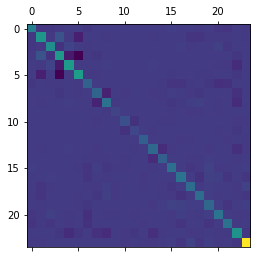

In [55]:
plt.matshow(P)